#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель:** построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#KNeighborsRegressor" data-toc-modified-id="KNeighborsRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>KNeighborsRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
!pip install scikit-learn==1.3 -q

In [2]:
!pip install lightgbm -q

In [3]:
# загрузка библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     cross_val_score, 
                                     TimeSeriesSplit
                                    )
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

import time

from sklearn.metrics import mean_squared_error

In [4]:
RANDOM_STATE = 42

In [5]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [6]:
# функция для просмотра общей информации о дф
def info(data):
    print(display(data.head()), data.info())

In [7]:
info(taxi)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None None


In [8]:
taxi.sort_index(inplace=True)

In [9]:
# ресемплирование
taxi = taxi.resample('1H').sum()

Данные о заказах такси с 1 марта по 31 августа 2018 года.

## Анализ

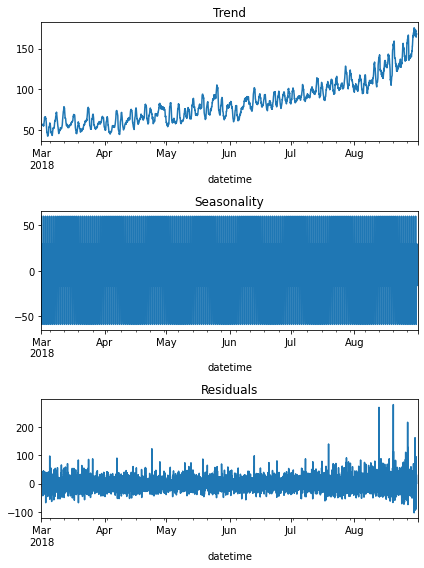

In [10]:
# разложение временного ряда
decomposed = seasonal_decompose(taxi) 

plt.figure(figsize=(6, 8))

# тренд
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

# сезонность
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

# остатки
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По тренду видно увеличение количества заказов такси со временем. По остаткам можно увидеть выбросы в августе. На данном этапе по сезонность ничего нельзя сказать.

<AxesSubplot:xlabel='datetime'>

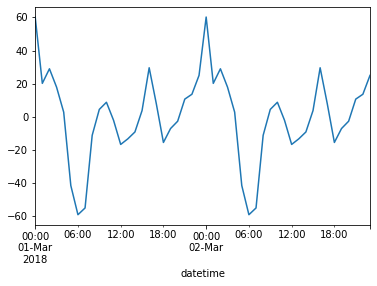

In [11]:
# сезонность в рамках 2-х дней
decomposed.seasonal[0:48].plot()

Присутствует суточная сезонность.

In [12]:
taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(24).mean()
taxi['std'] = taxi['num_orders'].shift().rolling(24).std()

<AxesSubplot:xlabel='datetime'>

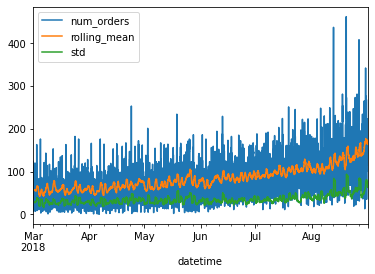

In [13]:
taxi.plot()

In [14]:
taxi = taxi.drop(['rolling_mean', 'std'], axis=1)

Ряд нестационарнный, так как среднее и стандартное отклонения меняются.

## Обучение

In [15]:
# создание признаков
def make_features(data, max_lag):
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()
    
    return df

In [16]:
df = make_features(taxi, 150)

In [17]:
# разделение на обучающую и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [18]:
X_train.shape

(3824, 155)

In [19]:
cv = TimeSeriesSplit(n_splits=3).split(X_train)

### LGBMRegressor

In [20]:
# гиперпараметры
param = {'n_estimators': range(10, 15),
         'learning_rate': [0.1, 0.05]
        }

# обучение DecisionTreeRegressor
lgbm = LGBMRegressor(force_row_wise=True, 
                     random_state=RANDOM_STATE
                    )

# GridSearchCV 
lgbm_gs = GridSearchCV(lgbm, 
                       param, 
                       scoring='neg_root_mean_squared_error', 
                       cv=3
                      )

In [21]:
# обучение LGBMRegressor
start = time.time()

lgbm_gs.fit(X_train, y_train)

lgbm_time = time.time() - start

In [22]:
# предсказание LGBMRegressor
start = time.time()
lgbm_preds = lgbm_gs.predict(X_train)
lgbm_time_pred = time.time() - start

### DecisionTreeRegressor

In [23]:
# гиперпараметры
param = {'max_depth': range(5, 10),
         'min_samples_leaf': range(5, 10),
         'min_samples_split': range(5, 10)
        }

# обучение DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

# GridSearchCV 
dtr_gs = GridSearchCV(dtr, 
                      param, 
                      scoring='neg_root_mean_squared_error', 
                      cv=3
                     )

start = time.time()

dtr_gs.fit(X_train, y_train)

dtr_time = time.time() - start

In [24]:
# предсказание  DecisionTreeRegressor
start = time.time()
dtr_preds = dtr_gs.predict(X_train)
dtr_time_pred = time.time() - start

### KNeighborsRegressor

In [25]:
# обучение KNeighborsRegressor
start = time.time()

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

knn_time = time.time() - start

In [26]:
# предсказание KNeighborsRegressor
start = time.time()
knn_preds = knn.predict(X_train)

knn_time_pred = time.time() - start

In [27]:
# кросс-валидация
knn_cv = cross_val_score(knn, 
                          X_train, 
                          y_train, 
                          cv=3,
                          scoring='neg_root_mean_squared_error'
                         ).mean() * (-1)

### LinearRegression

In [28]:
# обучение LinearRegression
start = time.time()

lr = LinearRegression()
lr.fit(X_train, y_train)

lr_time = time.time() - start

In [29]:
# предсказание LinearRegression
start = time.time()

lr_preds = lr.predict(X_train)

lr_time_pred = time.time() - start

In [30]:
# кросс-валидация
lr_cv = cross_val_score(lr, 
                        X_train, 
                        y_train, 
                        cv=3,
                        scoring='neg_root_mean_squared_error'
                       ).mean() * (-1)

### Вывод

In [31]:
# сравнение результатов
analisis = pd.DataFrame({'training_time': [lgbm_time, 
                                           dtr_time, 
                                           knn_time, 
                                           lr_time
                                          ],
                         'prediction_time': [lgbm_time_pred, 
                                             dtr_time_pred, 
                                             knn_time_pred, 
                                             lr_time_pred
                                            ],
                         'RMSE': [lgbm_gs.best_score_ * (-1), (dtr_gs.best_score_ * (-1)), knn_cv, lr_cv]
                        },
                        index = ['LGBMRegressor', 
                                 'DecisionTreeRegressor', 
                                 'KNeighborsRegressor', 
                                 'LinearRegression'
                                ]
                       )
analisis

,training_time,prediction_time,RMSE
LGBMRegressor,37.569577,0.007559,25.849690
DecisionTreeRegressor,64.047211,0.004925,26.904646
KNeighborsRegressor,0.005157,0.461167,26.010621
LinearRegression,0.396041,0.100157,23.100103


Лучшая метрика на кросс-валидации у модели LinearRegression, худшая - DecisionTreeRegressor. Время обучения у  DecisionTreeRegressor максимальное. LinearRegression - лучшая модель.

## Тестирование

In [32]:
print(f'Метрика RMSE на тестовой выборке лучшей модели:{round(mean_squared_error(y_test, lr.predict(X_test), squared=False))}')

Метрика RMSE на тестовой выборке лучшей модели:40


Значение метрики на тестовой выборке 40, что не превышает допустимого (48).

In [33]:
result = pd.DataFrame({'test': y_test,
                       'pred': lr.predict(X_test)
                      })

Text(0.5, 1.0, 'Реальные и предсказанные значения\n')

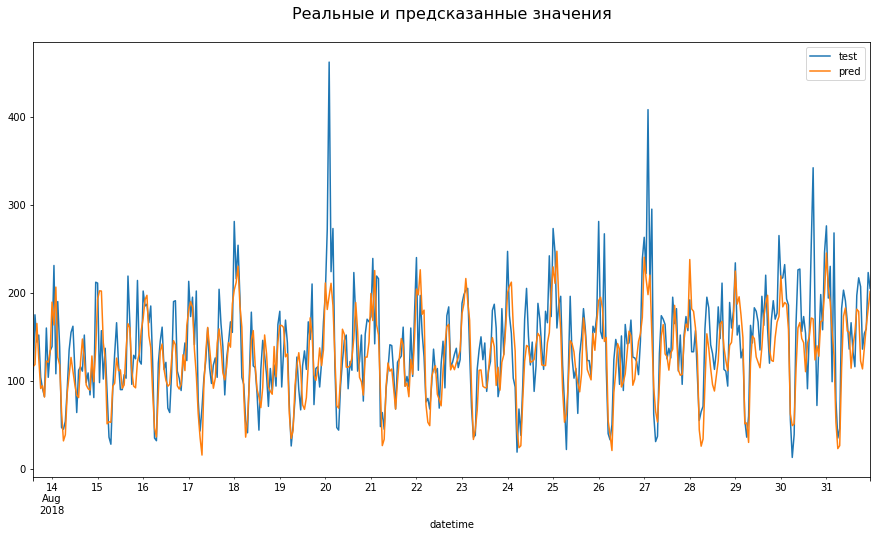

In [34]:
result.plot(figsize=(15, 8))
plt.title('Реальные и предсказанные значения' + "\n", fontsize=16)

Модель плохо предсказывает выбивающиеся значения. Это, возможно, произошло, так как в начальном дф при анализе остатков в августе были выбросы, которых не было до этого, и в тестовую выборку попали данные августа.

**Вывод:**
- Перед обучением был произведен анализ временного ряда. Выявлены следующие закономерности: 1) Количество заказов со временем увеличивается 2) Присутствует суточная сезонность 3) Ряд является нестационарным
- Для предсказания значений временного ряда были выбраны 4 модели: LGBMRegressor, DecisionTreeRegressor, KNeighborsRegressor, LinearRegression;
- По значениям метрики RMSE на кросс-валидации была выбрана лучшая модель - LinearRegression со значением метрики = 23;
- Значение RMSE на тестовой выборке не больше 48 и составляет 40.